In [0]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Dropout, Lambda
from keras.models import Model, load_model
from keras.datasets import cifar10
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD
from keras import backend as K
import numpy as np
import cv2
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Load and Preprocess the dataset

In [0]:
# Convert to grayscale
def converter(x):
    #x has shape (batch, width, height, channels)
    return (0.2989 * x[:,:,:,:1]) + (0.5870 * x[:,:,:,1:2]) + (0.1140 * x[:,:,:,-1:])

In [0]:
# load the dataset
(x_train, _), (x_test, _) = cifar10.load_data()

xtrain = converter(x_train)
xtest = converter(x_test)

xtrain = xtrain.astype('uint8')
xtest = xtest.astype('uint8')

# Canny Edge Detection
xtrain_temp=[]
for i in range(x_train.shape[0]):
  xtrain_temp.append(cv2.Canny(xtrain[i],100,200))

xtest_temp=[]
for i in range(x_test.shape[0]):
  xtest_temp.append(cv2.Canny(xtest[i],100,200))

xtrain = np.asarray(xtrain_temp)
xtest = np.asarray(xtest_temp)

xtrain = xtrain.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.

xtrain = xtrain.reshape(len(xtrain), np.prod(xtrain.shape[1:]))
xtest = xtest.reshape(len(xtest), np.prod(xtest.shape[1:]))

170500096/170498071 [==============================] - 12s 0us/step


# Define the model

In [0]:
input_layer = xtrain.shape[1]
hid_layer1 = 576
hid_layer2 = 256
hid_layer3 = 64
hid_layer4 = 10
hid_layer5 = hid_layer3
hid_layer6 = hid_layer2
hid_layer7 = hid_layer1
output_layer = input_layer
print(xtrain.shape)
print(xtest.shape)

(50000, 1024)
(10000, 1024)


In [0]:
input_img = Input(shape=(input_layer,))

W0829 00:17:11.417055 139949760759680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 00:17:11.451997 139949760759680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [0]:
# network architecture
# vanilla autoencoder with fully-connected layer
# ENCODER
x = Dense(units = hid_layer1, activation='relu')(input_img)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer2, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer3, activation='relu')(x)
# x = BatchNormalization()(x)

encoded = Dense(units = hid_layer4, activation='relu',kernel_regularizer = l2(3e-5), activity_regularizer = l1(10e-9))(x)

# DECODER
x = Dense(units = hid_layer5, activation = 'relu')(encoded)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer6, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer7, activation='relu')(x)
# x = BatchNormalization()(x)

decoded = Dense(units = output_layer, activation='sigmoid')(x)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer= Adam(lr = 1e-5), loss='binary_crossentropy')

W0829 00:17:13.033236 139949760759680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 00:17:13.144649 139949760759680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 00:17:13.151613 139949760759680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0829 00:17:13.155801 139949760759680 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, whi

In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 576)               590400    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               147712    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
__________

# Train Model

In [0]:
# train the model
history = autoencoder.fit(xtrain, xtrain,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(xtest, xtest))

W0829 00:17:20.362510 139949760759680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.6116 - val_loss: 0.5407
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.5276 - val_loss: 0.5162
Epoch 3/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5125 - val_loss: 0.5079
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5062 - val_loss: 0.5028
Epoch 5/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.5025 - val_loss: 0.5005
Epoch 6/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.5009 - val_loss: 0.4995
Epoch 7/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.5000 - val_loss: 0.4986
Epoch 8/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4989 - val_loss: 0.4970
Epoch 9/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4967 - val_loss: 0.4943
Epoc

dict_keys(['val_loss', 'loss'])


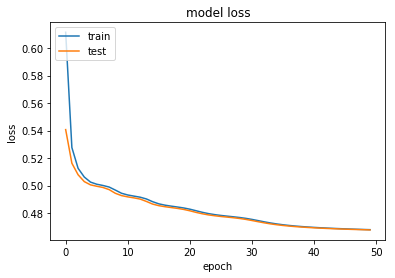

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

autoencoder.save('/content/gdrive/My Drive/autoencoder_edge.h5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# (Optional) Load Pre-Trained Model

In [0]:
from keras.models import load_model

autoencoder = load_model('/content/gdrive/My Drive/autoencoder_edge.h5')
enocder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer(index = 4).output)

# Reconstruction Results

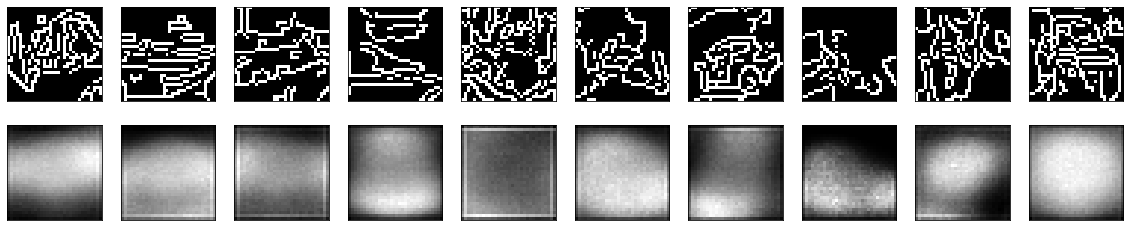

In [0]:
# show the result at the decoder output
decoded_imgs = autoencoder.predict(xtest)

counter = 0
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(xtest[counter + i].reshape(32, 32),cmap = 'gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[counter + i].reshape(32, 32),cmap = 'gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
abc = decoded_imgs[8] >= 0.4

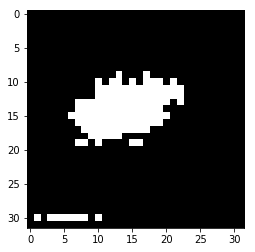

In [0]:
plt.imshow(abc.reshape(32,32))

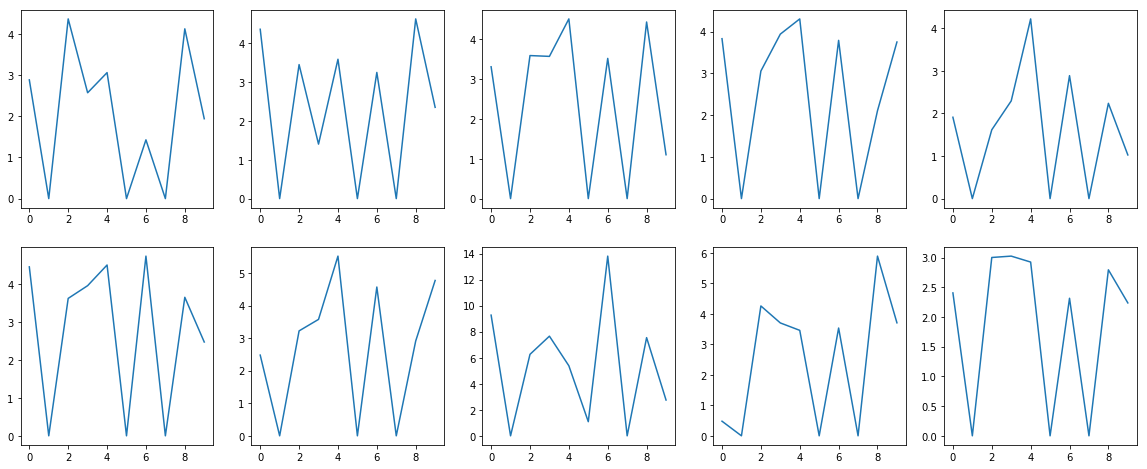

In [0]:
# show the representation at the bottleneck
encoded_imgs = encoder.predict(xtest)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs[counter + i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()